# Dimensionality Reduction and Generative Modeling using Wavelets

This notebook provides a description of a neural network algoritm that uses wavelets for dimensionality reduction and generative modeling. The code for the the model can be found in `wavelet.py` and `model.py`, although portions of it will also be reproduced here.

## A brief introduction to wavelets

A _wavelet_ is a wave that has a finite extent, such that its amplitude is zero outside of a limited domain. This is a very general definition, and the wavelets of interest to mathematicians and enginners tend to have additional useful properties, such as certain orthogonality conditions. The utility of wavelets comes from their ability to act as a basis for virtually any signal, which allows us to decompose the signal into a linear combination of wavelets. This is similar to the Fourier series for periodic functions, except that wavelets can resolve signal properties in both the frequency and time domains simultaneously. This makes them an exceptionally powerful tool for signal analysis, especially on image and time-series data.

When working with wavelets, there are two key sets of functions: the _scaling functions_ $\phi_{j,k}$ and the _wavelet functions_ $\psi_{j,k}$. Each set of functions is generated by a single _mother_ function, which is scaled and translated by fixed amound to generate the indexed functions:

\begin{equation}
\phi_{j,k}(x) = 2^{\frac{j}{2}} \phi(2^jx - k), \quad \quad \psi_{j,k}(x) = 2^{\frac{j}{2}} \psi(2^jx - k)
\end{equation}

For a given $j$, the scaling functions span a a vector space that can  describe a signal up to a certain level of detail, with higher values of $j$ corresponding to greater resolution. The $j$th wavelet function set spans the difference between the scaling spaces corresponding to $j$ and $j+1$, and can be viewed as adding back the detail that is lost in the coarser space. In the following code, we plot examples of the scaling and wavelet mother functions for the "Daubechies 4" wavelet using the libary PyWavelets:

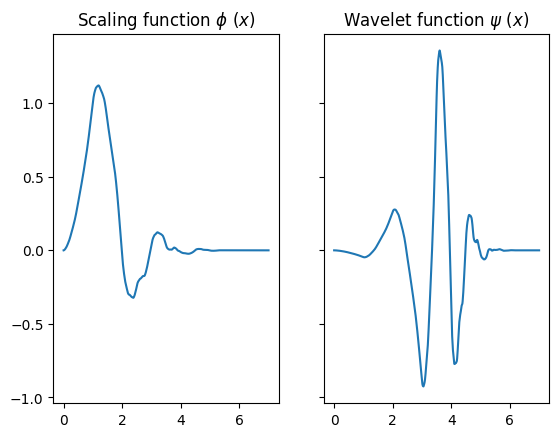

In [1]:
import pywt
import matplotlib.pyplot as plt

w = pywt.Wavelet('db4')
(phi, psi, x) = w.wavefun(level=20)

(fig, [ax_1, ax_2]) = plt.subplots(1, 2, sharey = True)
ax_1.plot(x, phi)
ax_2.plot(x, psi)
ax_1.set_title(r"Scaling function $\phi\ (x)$")
ax_2.set_title(r"Wavelet function $\psi\ (x)$")
plt.show()

Note that the functions have a highly irregular shape, and do not possess any closed-form solution. Instead, their shapes are generated on demand using a numerical algorithm.

In a _wavelet decomposition_, we project a signal into a specified scaling space depending on the level $j$ of detail desired, which generates a set of expansion coefficients for the $j$th set of scale functions plus coefficients for the wavelet spaces corresponding to each coarse-graining step. The original signal can always be reconstructed from the coarse-grained signal by adding back the wavelet terms, although if these terms are unknown then the fine-grained structure of the signal will be lost. The following code block shows a custom Keras layer in TensorFlow that carries out a wavelet decomposition on the input signal:

In [2]:
import tensorflow as tf

class Wavelet_Decon(tf.keras.layers.Layer):
    def __init__(self, h, axis, **kwargs):

        # The h_0 and h_1 attributes are the filter values for 
        # computing the scale coefficients and wavelet coefficients
        # respectively.

        super().__init__(**kwargs)
        h = tf.constant(h)
        indices = tf.range(tf.size(h))
        self.h_0 = h[:, tf.newaxis, tf.newaxis]
        self.h_1 = tf.reverse(tf.dynamic_stitch([indices[::2], indices[1::2]], [-h[::2], h[1::2]]), [0])[:, tf.newaxis, tf.newaxis]
        self.basis_indices = tf.range(tf.size(h) - 1)
        self.axis = axis

    def build(self, input_shape):

        # The permute attribute simply specifies indices for a 
        # transposition that places the target axis at the end
        # of the tensor shape.

        num_dims = input_shape.rank
        self.permute = tf.dynamic_stitch([tf.range(num_dims), [self.axis, num_dims-1]], [tf.range(num_dims), [num_dims-1, self.axis]])

    def call(self, inputs):

        # To perform the decomposition, the input is first 
        # appended with a truncated copy of itself so that 
        # it is big enough to allow the filters to act on all
        # featutes. Then the scale and wavelet coefficients 
        # are computed by convolving the expanded input
        # with h_0 and h_1.

        inputs = tf.transpose(inputs, self.permute)
        cycle_indices = self.basis_indices % tf.shape(inputs)[-1]
        periodic_coeff = tf.concat([inputs, tf.gather(inputs, cycle_indices, axis = -1)], axis = -1)
        h_0_conv = tf.nn.conv1d(periodic_coeff[..., tf.newaxis], self.h_0, stride = 1, padding = "VALID")[..., 0]
        h_1_conv = tf.nn.conv1d(periodic_coeff[..., tf.newaxis], self.h_1, stride = 1, padding = "VALID")[..., 0]
        scale_coeff = tf.transpose(h_0_conv[..., ::2], self.permute)
        wavelet_coeff = tf.transpose(h_1_conv[..., ::2], self.permute)
        outputs = tf.concat([scale_coeff, wavelet_coeff], self.axis)
        return outputs

The core operations within this layer are the pair of convolutions that act on a specified axis of the input. The filters for these convolution are based on the specific choice of wavelet, and allow us to easily compute the scale coefficients for the coarse-grained output along with the associated wavelet coefficients. To compute the wavelet decomposition on higher-dimensional data, we can simply apply this layer on each of the feature axes. The following code shows how the wavelet decomposition acts on an image from the MNIST dataset:

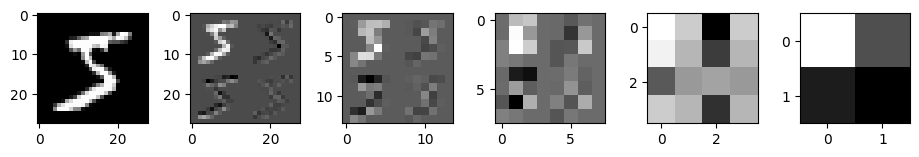

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf

import wavelet

image = tf.keras.datasets.mnist.load_data()[0][0][0]
image = tf.cast(image, "float32") / 255
padded_image = wavelet.Pad_nD()(image)
decon_layer = wavelet.Wavelet_Decon_Layer(wavelet.haar)

decon = decon_layer(image[None])

(fig, axes) = plt.subplots(1, len(decon), figsize = (9.3, 7))
for (ax, coeff) in zip(axes, reversed(decon)):
    ax.imshow(coeff[0], cmap = "gray")
plt.tight_layout()
plt.show()

In this sequence of plots, we can see the original image of a five on the left, followed by images of decreasing resolution which appear to be divided into four quadrants. The top left quadrant shows the coarse-grained image generated by the wavelet decomposition, while the other three quadrants show the fine-grained detail that was lost relative to the image before it. In the most extreme case, the wavelet decomposition reduces the image down to only a single pixel, but even this level of coarse-graining can be undone by recombining the other three quadrants via an _inverse wavelet decomposition_. Code for a Keras layer that carries out the inverse decomposition is given here:

In [4]:
class Wavelet_Recon(tf.keras.layers.Layer):
    def __init__(self, h, axis, **kwargs):

        # The h_0 and h_1 attributes are the filter values for 
        # reconstructing portions of the image from the scale
        # coefficients and wavelet coefficients respectively.

        super().__init__(**kwargs)
        h = tf.constant(h)
        indices = tf.range(tf.size(h))
        self.h_0 = h[::-1, tf.newaxis, tf.newaxis]
        self.h_1 = tf.reverse(tf.dynamic_stitch([indices[::2], indices[1::2]], [-h[::2], h[1::2]]), [0])[::-1, tf.newaxis, tf.newaxis]
        self.basis_indices = tf.range(-(tf.size(h) - 2)//2 - 1, 0)
        self.axis = axis

    def build(self, input_shape):

        # The permute attribute simply specifies indices for a 
        # transposition that places the target axis at the end
        # of the tensor shape.

        num_dims = input_shape[0].rank
        self.permute = tf.dynamic_stitch([tf.range(num_dims), [self.axis, num_dims-1]], [tf.range(num_dims), [num_dims-1, self.axis]])

    def call(self, inputs):

        # The layer takes as input a list of two tensors,
        # which hold the scale and wavelet coefficients
        # respectively. To recover the original data shape,
        # zeroes are inserted into the data and then convolved
        # with the h_0 and h_ attributes to generate the 
        # reconstruction.

        inputs = tf.stack([tf.transpose(inputs[0], self.permute), tf.transpose(inputs[1], self.permute)])
        cycle_indices = self.basis_indices % tf.shape(inputs)[-1]
        new_inputs = tf.concat([tf.gather(inputs, cycle_indices, axis = -1), inputs], axis = -1)[..., 1:]
        batch_shape = tf.shape(inputs)[:-1]
        up_shape = tf.concat([batch_shape, 2*tf.shape(new_inputs)[-1:]], 0)
        coeff_up = tf.reshape(tf.stack([tf.zeros_like(new_inputs), new_inputs], -1), up_shape)
        coeff_up = tf.concat([coeff_up, tf.zeros_like(coeff_up[..., 0:1])], -1)

        scale_coeff = coeff_up[0]
        wavelet_coeff = coeff_up[1]
        h_0_conv = tf.nn.conv1d(scale_coeff[..., tf.newaxis], self.h_0, stride = 1, padding = "VALID")[..., 0]
        h_1_conv = tf.nn.conv1d(wavelet_coeff[..., tf.newaxis], self.h_1, stride = 1, padding = "VALID")[..., 0]
        outputs = tf.transpose(h_0_conv + h_1_conv, self.permute)
        return outputs

This layer is similar to that of the wavelet decomposition, except that there are more manipulations of the input to get it into the correct configuration. The core operation though is still a pair of convolutions with filters that are determined by the type of wavelet used in the original decomposition.

## Wavelet reconstruction using neural networks

Wavelet reconstruction (i.e. the inverse wavelet decomposition) can always be carried out exactly if we have access to the wavelet coefficients corresponding to each of the coarse-graining operations. However, what if all we had were the scale coefficients? Would it still be possible to reconstruct the signal? For a random signal the answer is clearly no, since a virtually infinite number of higher-resolution signals can correspond to a given coarse-grained signal. That said, if we restrict ourselves a narrow class of inputs, then it may be possible to infer the missing wavelet coefficients based on the values of the scale coefficients.

This task can be understood as a problem in generative modeling, and it should be possible to carry out using a well-trained neural network. Given a full-resolution training sample, we can perform a sequence of wavelet decomposition down to a specified level of coarse-graining, with each decomposition yielding a set of scale coefficients and a set of wavelet coefficients. These sets of coefficients serve as our inputs and target outputs respectively, and we can use them to train a model at each coarse-graining level. Once these models have been trained, we can take a sample from the coarse-grained signal space and upscale it back to the original resolution. The following code show a composite Keras model that can carry out wavelet reconstruction on MNIST images:

In [5]:
import math
import tensorflow as tf

class Wavelet_MNIST():
    def __init__(self, h):

        # Create layers that will carry out the wavelet decomposition
        # and reconstruction. 

        self.pad_layer = wavelet.Pad_nD()
        self.decon_layer = wavelet.Wavelet_Decon_Layer(h, coarse_only = True)
        self.recon_layer = wavelet.Wavelet_nD_Recon(h)

    def build(self):

        # Each of the model cores correspond to a different
        # coarse-grained input size. The 1x1 and 2x2 models
        # are dense networks, while the remaining models
        # are convolutional. 

        self.models = []
        self.cores = []

        model_1_core = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, "relu"),
            tf.keras.layers.Dense(128, "relu"),
            tf.keras.layers.Dense(32, "relu"),
            tf.keras.layers.Dense(3),
            tf.keras.layers.Reshape([1, 1, 3])
        ])
        model_1 = self.assemble_model(model_1_core, 1)
        self.cores.append(model_1_core)
        self.models.append(model_1)

        model_2_core = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, "relu"),
            tf.keras.layers.Dense(128, "relu"),
            tf.keras.layers.Dense(32, "relu"),
            tf.keras.layers.Dense(12),
            tf.keras.layers.Reshape([2, 2, 3])
        ])
        model_2 = self.assemble_model(model_2_core, 2)
        self.cores.append(model_2_core)
        self.models.append(model_2)

        model_4_core = tf.keras.models.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, -1)),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(3, 3, padding = "same")
        ])
        model_4 = self.assemble_model(model_4_core, 4)
        self.cores.append(model_4_core)
        self.models.append(model_4)
        
        model_8_core = tf.keras.models.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, -1)),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(3, 3, padding = "same")
        ])
        model_8 = self.assemble_model(model_8_core, 8)
        self.cores.append(model_8_core)
        self.models.append(model_8)

        model_16_core = tf.keras.models.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, -1)),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
            tf.keras.layers.Conv2D(3, 3, padding = "same")
        ])
        model_16 = self.assemble_model(model_16_core, 16)
        self.cores.append(model_16_core)
        self.models.append(model_16)

    def train_all(self, train_images, test_images, epochs, batch_size, save = False):
        for i in range(len(self.models)):
            length = 2**i
            print(f"Training model_{length}")
            self.train(length, train_images, test_images, epochs, batch_size, save)

    def train(self, length, train_images, test_images, epochs, batch_size, save = False):

        # Each model is trained using the exact decomposition coefficients, rather than the
        # reconstructed output from the previous layers. The "length" argument sets which
        # coarse-graining level should be used for training.

        train_data = self.wavelet_transform(train_images.shuffle(60000).batch(batch_size), length)
        test_data = self.wavelet_transform(test_images.batch(batch_size), length)
        index = int(math.log2(length))
        model = self.models[index]

        model.compile(
            loss = "mae",
            optimizer = tf.keras.optimizers.RMSprop(0.0005))
        model.fit(
            train_data,
            epochs = epochs, 
            validation_data = test_data,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)])
        if save:
            core = self.cores[index]
            core.save(f"mnist_models/wavelet/core_{length}")

    def assemble_model(self, core, length):

        # This function adds the wavelet reconstruction layer
        # to the model core.

        first = tf.keras.layers.Input([length, length])
        fine = core(first)
        combined = tf.keras.layers.Lambda(
            lambda x: tf.concat([
                tf.concat([x[0], x[1][..., 0]], axis = 2),
                tf.concat([x[1][..., 1], x[1][..., 2]], axis = 2)
            ], axis = 1)
        )([first, fine])
        recon = self.recon_layer(combined)
        model = tf.keras.Model(inputs = [first], outputs = [recon])
        return model

    def wavelet_transform(self, dataset, length, keep_orig = False):

        # This function carries out a wavelet decomposition on the
        # inputs using the decon_layer.

        index = int(math.log2(length))
        padded = dataset.map(lambda x: self.pad_layer(x))
        if keep_orig:
            coeff = padded.map(lambda y: (self.decon_layer(y)[index], y))
        else:
            coeff = padded.map(lambda y: (self.decon_layer(y)[index], self.decon_layer(y)[index + 1]))
        return coeff

    def reconstruct(self, inputs, length = None):

        # This function uses the model to appoximately reconstructs 
        # the original input based on its coarse-grained scale 
        # coefficients.

        if length is None:
            length = tf.shape(inputs)[1]
        start_index = int(math.log2(length))
        next_input = inputs
        for i in range(start_index, 5):
            model = self.models[i]
            next_input = model(next_input)
        return next_input

Note that there is a model core for each resolution, from the original (padded) 32 x 32 images to the maximually coarse-grained 1 x 1 pixel "image". To evaluate the performance of the model, we can perform a sequence of wavelet decomposition on an image and then use the model to reconstruct the image starting from each of the possible coarse-graining levels. We should expect to get nearly perfect reconstruction after only a single coarse-graining step, since little information has been lost. After several coarse-graining steps, however, perfect reconstruction is likely to be impossible due to large amount of image detail that has been discarded. The code below shows the deconstruction and reconstruction of an image at different coase-graining levels:

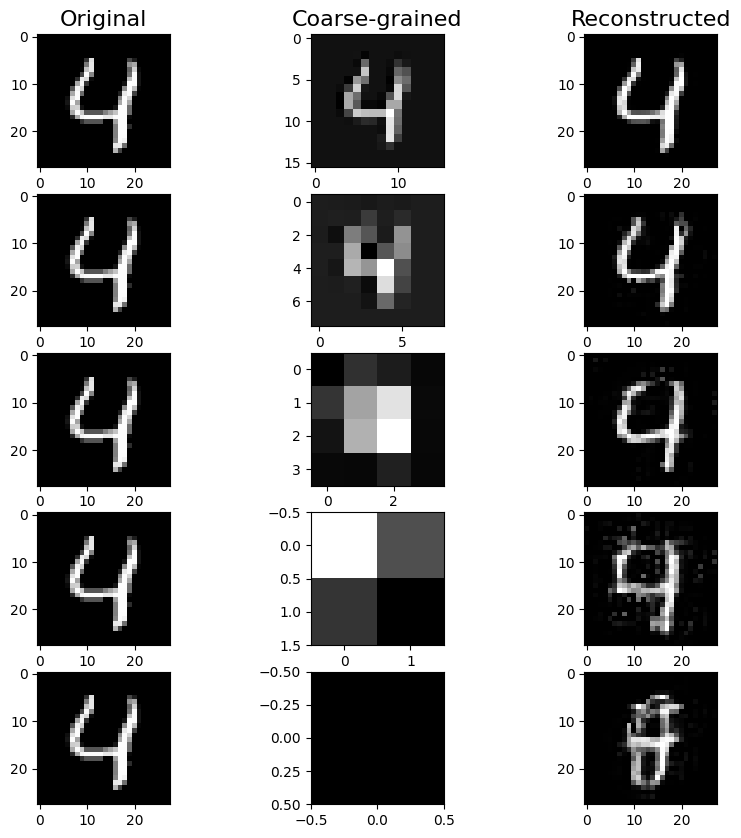

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import wavelet
import mnist_model

test_image = tf.keras.datasets.mnist.load_data()[1][0][4]
test_image = tf.cast(test_image, "float32") / 255
dataset = tf.data.Dataset.from_tensors(test_image[None])

model = mnist_model.Wavelet_MNIST(wavelet.d_4)
model.load()

(fig, axes) = plt.subplots(5, 3, figsize = (10, 10))
for (length, (ax_1, ax_2, ax_3)) in zip([16, 8, 4, 2, 1], axes):
    decon = next(iter(model.wavelet_transform(dataset, length)))[0]
    raw_recon = model.reconstruct(decon)[0]
    final_recon = mnist_model.clip_pixels(raw_recon)[2:30, 2:30]
    ax_1.imshow(test_image, cmap = "gray")
    ax_2.imshow(decon[0], cmap = "gray")
    ax_3.imshow(final_recon, cmap = "gray")
axes[0][0].set_title("Original", fontsize = 16)
axes[0][1].set_title("Coarse-grained", fontsize = 16)
axes[0][2].set_title("Reconstructed", fontsize = 16)
plt.show()

In each row, the original image of the digit "4" is given on the left, and the reconstruction generated by the model is shown on the right. In the middle column, we show the coarse-grained image, which is seen to lose resolution by a factor of two along each dimension as we go down the rows. As the size of the coarse-grained image space decreases, we can easily see the expected degradation of the reconstruction quality, though the output still shows impressive fidelity.

When working with reconstructions from the lower-resolution decompositions, we can observe an increase in noise or "static" from the reconstruction, which clearly does not fit into the normal appearance of the MNIST images. These reconstructions would look much more convincing if we could remove the obvious noise artifacts, so we will train a secondary model to perform this clean up. The following code creates the cleaner model using a method on the Wavelet_MNIST class:

In [9]:
import tensorflow as tf

def train_cleaner(self, length, train_images, test_images, epochs, batch_size):
    self.cleaner = tf.keras.models.Sequential([ # The cleaner is deliberately shallow.
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, -1)),
        tf.keras.layers.Conv2D(128, 3, padding = "same", activation = "relu"),
        tf.keras.layers.Conv2D(1, 3, activation = "sigmoid", padding = "same"),
        tf.keras.layers.Reshape([32, 32])
    ])
    first = tf.keras.layers.Input([length, length])
    recon = self.reconstruct(first, length)
    cleaned = self.cleaner(recon)

    model = tf.keras.Model(inputs = [first], outputs = [cleaned])
    for core in self.cores:
        core.trainable = False
    model.compile(
        loss = "mae",
        optimizer = tf.keras.optimizers.RMSprop(0.0005))
    
    train_data = self.wavelet_transform(train_images.shuffle(60000).batch(batch_size), length, True)
    test_data = self.wavelet_transform(test_images.batch(batch_size), length, True)
    model.fit(
        train_data,
        epochs = epochs, 
        validation_data = test_data,
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)])

With this cleaning model, the reconstruction can be made to more closely resemble images from the MNIST dataset, even if its overall appearance still differs somewhat from original image that was decomposed. The following code shows some examples of model reconstruction using the cleaner:

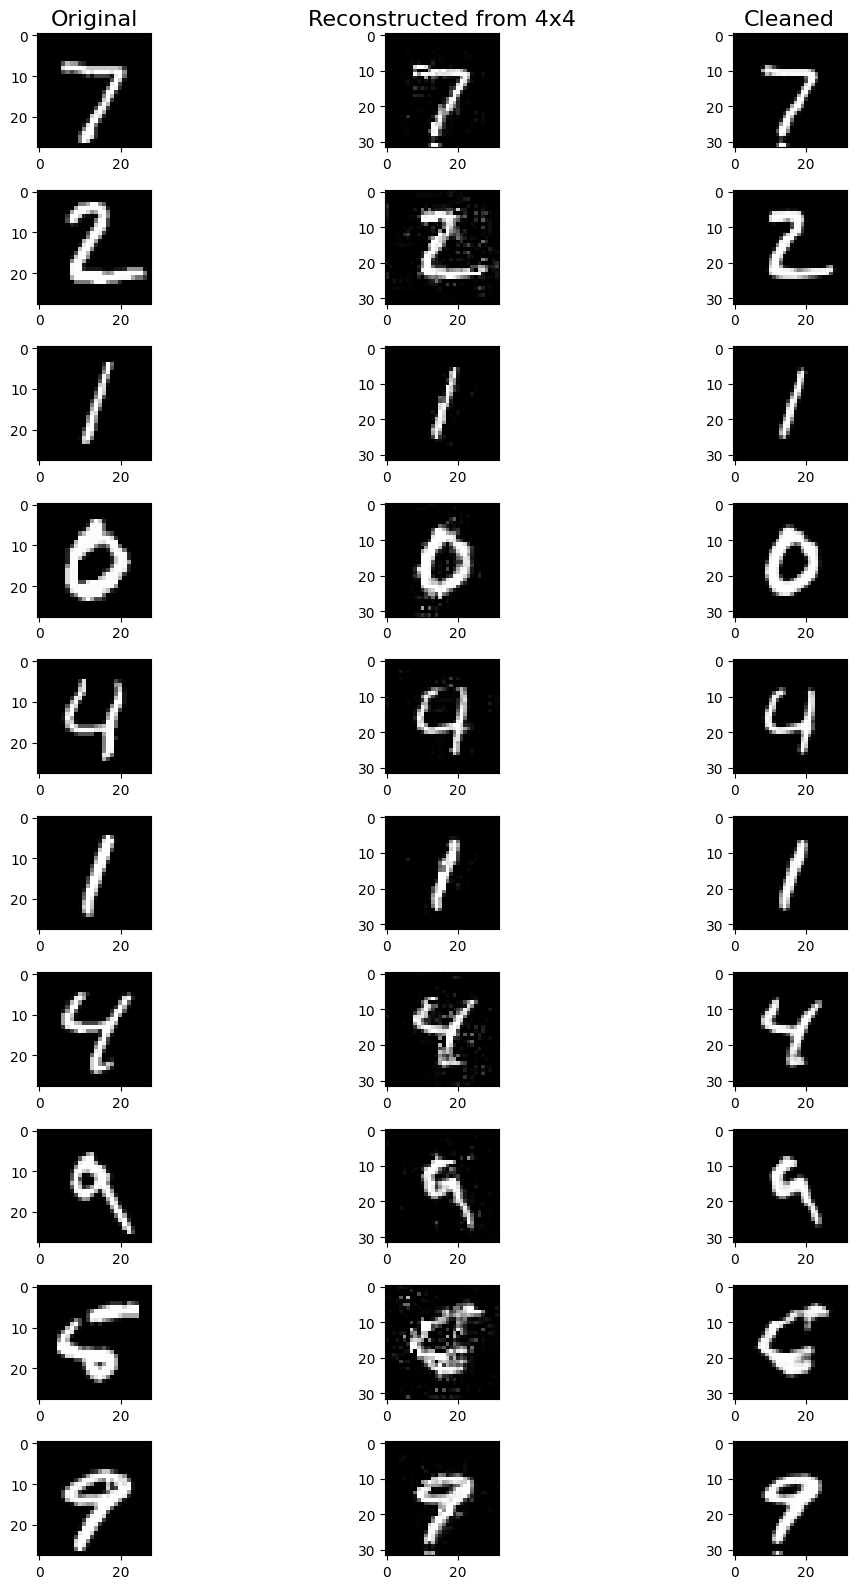

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import wavelet
import mnist_model

test_images = tf.keras.datasets.mnist.load_data()[1][0]
test_images = tf.cast(test_images, "float32") / 255
dataset = tf.data.Dataset.from_tensors(test_images[:10])

model = mnist_model.Wavelet_MNIST(wavelet.d_4)
model.load()

decon = next(iter(model.wavelet_transform(dataset, 4)))[0]
recon = model.reconstruct(decon)
clipped = mnist_model.clip_pixels(recon)
cleaned = model.clean(recon)
(fig, axes) = plt.subplots(10, 3, figsize = (12 ,16))
for (orig_image, recon_image, clean_recon_image, (ax_1, ax_2, ax_3)) in zip(test_images, clipped, cleaned, axes):
    ax_1.imshow(orig_image, cmap = "gray")
    ax_2.imshow(recon_image, cmap = "gray")
    ax_3.imshow(clean_recon_image, cmap = "gray")
axes[0][0].set_title("Original", fontsize = 16)
axes[0][1].set_title("Reconstructed from 4x4", fontsize = 16)
axes[0][2].set_title("Cleaned", fontsize = 16)
plt.tight_layout()
plt.show()

Comparing the second and third columns, we can see that the cleaner is able to fix most irregularities in the brightness and location of the image pixels, although broader discrepencies in shape will not be addressed. 

## Generating novel images

So far we have focused on reconstructing existing images that were coarse-grained via wavelet decomposition, but it is also possible to view the low-resolution image space as a latent space for an image-generating model. At the smallest resolution sizes, such as 2x2, it is possible to use a Gaussian distribution to generate the initial probability density on the latent space. The Gaussian distributions can be fit to a set of coarse-grained images generated from the wavelet decomposition of a training set. The following method for the Wavelet_MNIST class generates novel images using this Gaussian approach:

In [3]:
import tensorflow_probability as tfp

def sample_gaussian(self, dataset, length, num_samples):
    decon = self.wavelet_transform(dataset.batch(60000), length)
    data = tf.reshape(next(iter(decon))[0], [60000, -1])
    cov = tfp.stats.covariance(data)
    mean = tf.reduce_mean(data, 0)
    samples = tfp.distributions.MultivariateNormalFullCovariance(mean, cov).sample([num_samples])
    recon = self.reconstruct(tf.reshape(samples, [num_samples, length, length]))
    cleaned = self.cleaner(recon)[:, 2:30, 2:30]
    return cleaned

We can use this method to sample a set of new images and see how realistic they look. Given that the Gaussian distribution does not posesses a sophisticated structure, we will get the best results by using the small 2x2 coarse-grained latent space.

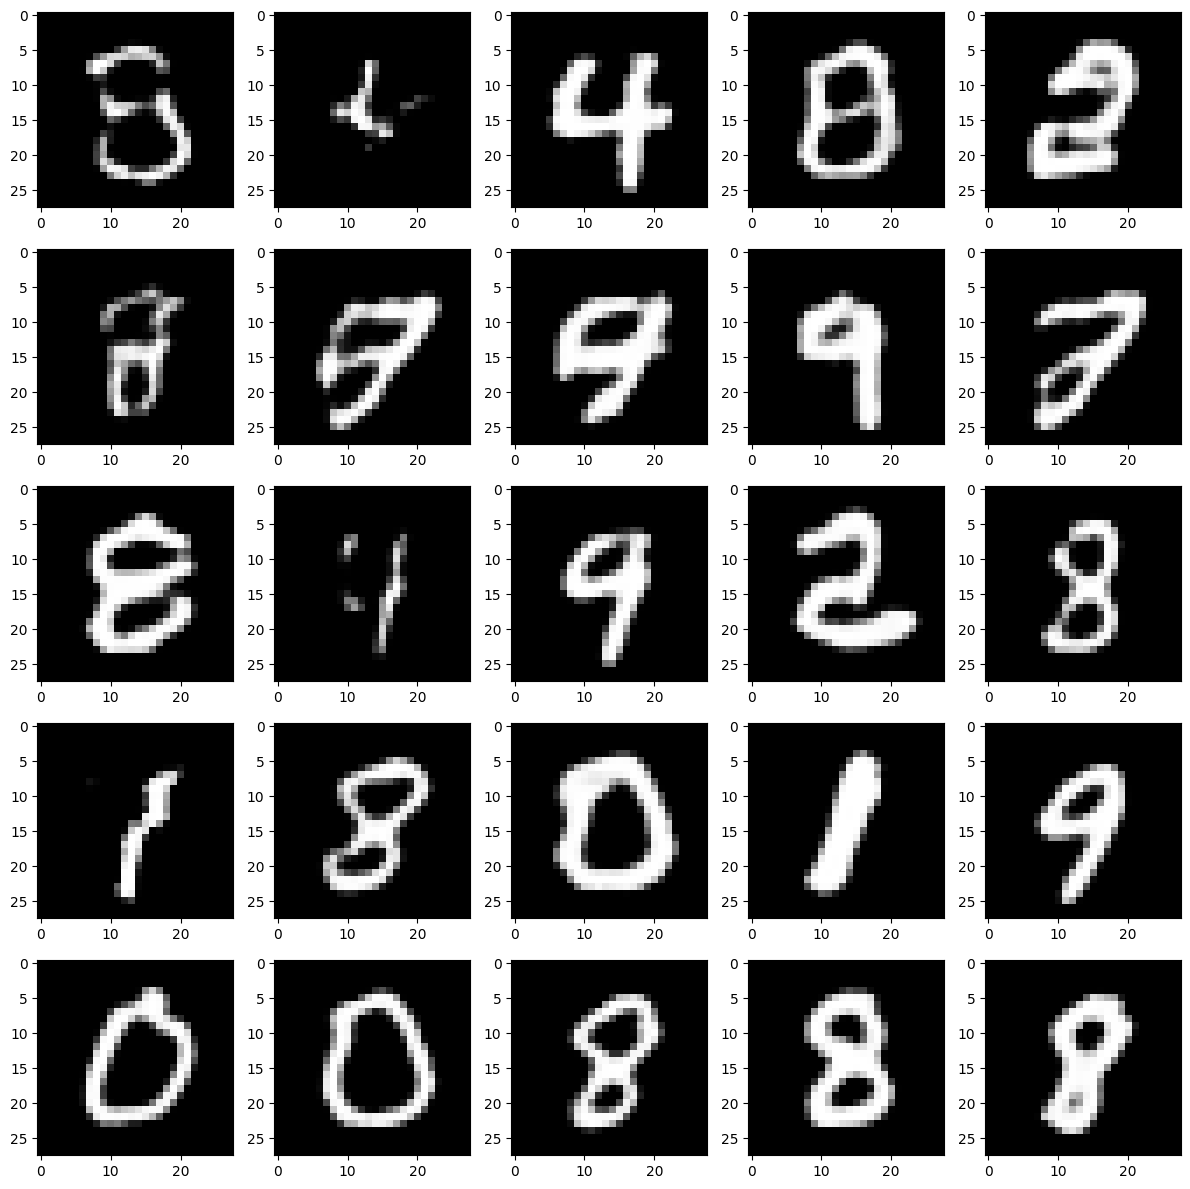

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import wavelet
import mnist_model

(train_images, test_images) = mnist_model.get_images()

model = mnist_model.Wavelet_MNIST(wavelet.d_4)
model.load()

samples = tf.reshape(model.sample_gaussian(train_images, 2, 25), [5, 5, 28, 28])
(fig, axes) = plt.subplots(5, 5, figsize = (12, 12))
for i in range(5):
    for j in range(5):
        axes[i][j].imshow(samples[i, j], cmap = "gray")
plt.tight_layout()
plt.show()

As we can see from the plots, virually all of the images are at least vaguely digit-shaped, with a fair number being reasonable depictions. That said, quite a few are clearly not digits, which suggests that there are portions of the latent space which do not map to decomposed MNIST images. 